# Plotting the predictions of the single- and multi-center RPN signatures
- This jupyter notebook is available on-line at:
  - https://github.com/spisakt/RPN-signature/blob/master/notebooks/3_compare_predictions.ipynb
- Input data for the notebook and non-standard code (PAINTeR library) is available in the repo:
  - https://github.com/spisakt/RPN-signature
- Raw MRI-data from study-centers 1 and 2 are available on OpenNeuro:
  - https://openneuro.org/datasets/ds002608/versions/1.0.1
  - https://openneuro.org/datasets/ds002609/versions/1.0.3
- Raw data from center 3 is available upon reasonable request.

## Imports

In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from mlxtend.evaluate import permutation_test
from mlconfound.stats import partial_confound_test
from mlconfound.plot import plot_null_dist, plot_graph
from scipy.stats import f_oneway
from scipy import stats

import sys
sys.path.append('../')
from PAINTeR import plot # in-house lib used for the RPN-signature

from tqdm import tqdm

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Load and merge behavioral data for all three centers (after exclusions)

In [2]:
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
y = df.mean_QST_pain_sensitivity

## Load predictions for the original single-center and the newly proposed multi-center model

In [3]:
# predictions
multicener_predictions = np.genfromtxt('../res/multi-center/nested_cv_pred_full_GroupKFold30.csv', delimiter=',')
rpn_predictions = np.hstack((df_bochum.nested_prediction,
                            df_essen.prediction,
                            df_szeged.prediction))

predictions = {
    'single-center' : rpn_predictions,
    'multi-center' : multicener_predictions
}

### create study masks

In [4]:
study_masks = {
    "study 1" : (df.study == 'bochum').values,
    "study 2" : (df.study == 'essen').values,
    "study 3" : (df.study == 'szeged').values,
    "study 1+2+3" : np.array([True] * len(y))
}

## Observed vs. Predicted plots

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


*** single-center study 1 ****************************************************
R=0.45
p_corr=0.00375
MSE=0.43
MSE=0.46
Expl. Var. =0.185
*** single-center study 2 ****************************************************
R=0.43


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p_corr=0.00337
MSE=0.54
MSE=0.59
Expl. Var. =0.181
*** single-center study 3 ****************************************************
R=0.47


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p_corr=0.02312
MSE=0.44
MSE=0.57
Expl. Var. =0.170
*** single-center study 1+2+3 ****************************************************
R=0.42


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p_corr=0.00025
MSE=0.47
MSE=0.54
Expl. Var. =0.164
*** multi-center study 1 ****************************************************
R=0.61


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p_corr=0.00037
MSE=0.35
MSE=0.45
Expl. Var. =0.343
*** multi-center study 2 ****************************************************
R=0.59


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p_corr=0.00012
MSE=0.42
MSE=0.54
Expl. Var. =0.340
*** multi-center study 3 ****************************************************
R=0.51


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p_corr=0.01262
MSE=0.22
MSE=0.37
Expl. Var. =0.262
*** multi-center study 1+2+3 ****************************************************
R=0.63


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p_corr=0.00012
MSE=0.35
MSE=0.47
Expl. Var. =0.382


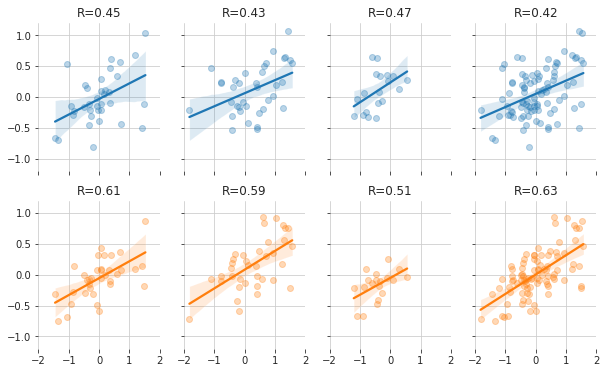

In [5]:
sns.set_style('ticks')
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(10,6), sharex=True, sharey=True)

cols = ['tab:blue', 'tab:orange']

for row, cv in enumerate(predictions.keys()):
    for col, study in enumerate(study_masks.keys()):
        g=sns.regplot(y[study_masks[study]], predictions[cv][study_masks[study]], ax=axs[row, col],
                    scatter=True, scatter_kws={'alpha':0.3}, color=cols[row])
        g.set(xlabel=None) 
        axs[row, col].set_xlim([-2, 2])
        axs[row, col].set_ylim([-1.2, 1.2])
        axs[row, col].spines['top'].set_visible(False)
        axs[row, col].spines['bottom'].set_visible(False)
        axs[row, col].spines['right'].set_visible(False)
        axs[row, col].spines['left'].set_visible(False)
        axs[row, col].grid(True)
        
        print('***', cv, study, '****************************************************')
                   
        corr = np.corrcoef(y[study_masks[study]], predictions[cv][study_masks[study]])[0,1]
        axs[row, col].title.set_text("R={:.2f}".format(corr))
        print("R={:.2f}".format(corr))
        
        # takes some seconds
        p_corr = permutation_test(y[study_masks[study]], predictions[cv][study_masks[study]],
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
        print("p_corr={:.5f}".format(p_corr))
        
        mse = mean_squared_error(y[study_masks[study]], predictions[cv][study_masks[study]])
        print("MSE={:.2f}".format(mse))
        
        mae = mean_absolute_error(y[study_masks[study]], predictions[cv][study_masks[study]])
        print("MSE={:.2f}".format(mae))
        
        expvar = explained_variance_score(y[study_masks[study]], predictions[cv][study_masks[study]])
        print("Expl. Var. ={:.3f}".format(expvar))
   
   
        
plt.savefig('../res/multi-center/regplots_obs-pred.pdf')

# "Classification" performance


## Violoin plots per center for the observed and predicted values

In [14]:
from sklearn.metrics import roc_curve, auc

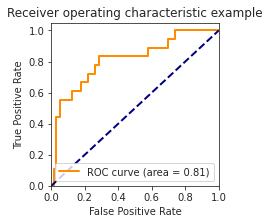

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mean_QST_pain_sensitivity', ylabel='Density'>

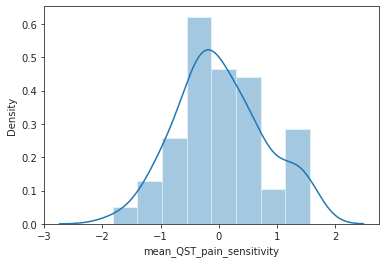

In [56]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y>np.quantile(y,0.8), predictions['multi-center'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(3,3))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.savefig('../res/multi-center/roc_80.pdf')
plt.show()

sns.distplot(y)


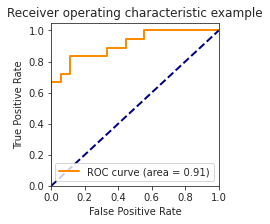

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


array([-0.47485478,  0.62944628])

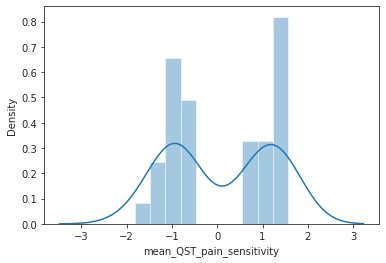

In [57]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

quants = np.quantile(y, (0.20, 0.80))

y_lohi = y[np.logical_or(y<quants[0],  y>quants[1])]
pred_lohi = predictions['multi-center'][np.logical_or(y<quants[0],  y>quants[1])]

fpr, tpr, _ = roc_curve(y_lohi>np.median(y), pred_lohi)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(3,3))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.savefig('../res/multi-center/roc_20-80.pdf')
plt.show()

sns.distplot(y_lohi, bins=10)
quants

In [59]:
np.corrcoef(df.mean_QST_pain_sensitivity[~np.isnan(df.mean_QST_pain_sensitivityd2)], df.mean_QST_pain_sensitivityd2[~np.isnan(df.mean_QST_pain_sensitivityd2)])

array([[1.        , 0.82101999],
       [0.82101999, 1.        ]])

<AxesSubplot:xlabel='study'>

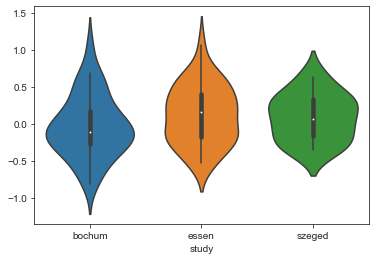

In [9]:
sns.violinplot(data=df, x='study', y=predictions['single-center'])

<AxesSubplot:xlabel='study'>

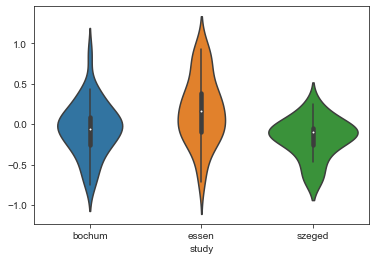

In [10]:
sns.violinplot(data=df, x='study', y=predictions['multi-center'])

<AxesSubplot:xlabel='study', ylabel='mean_QST_pain_sensitivity'>

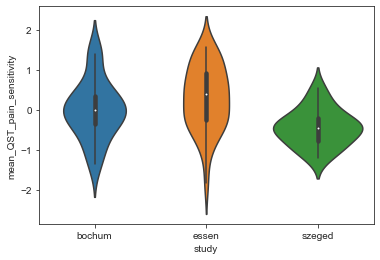

In [11]:
sns.violinplot(data=df, x='study', y='mean_QST_pain_sensitivity')

In [12]:
print(df.mean_QST_pain_sensitivity[df.study=='bochum'].mean())
print(df.mean_QST_pain_sensitivity[df.study=='essen'].mean())
print(df.mean_QST_pain_sensitivity[df.study=='szeged'].mean())

f_oneway(df.mean_QST_pain_sensitivity[df.study=='bochum'],
        df.mean_QST_pain_sensitivity[df.study=='essen'],
        df.mean_QST_pain_sensitivity[df.study=='szeged'])

0.008551403888578259
0.289473414953464
-0.435775823593041


F_onewayResult(statistic=6.5055415995744355, pvalue=0.00231739640326624)

## Partial confounder test for site effect:

Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 398.24it/s]


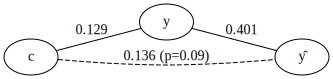

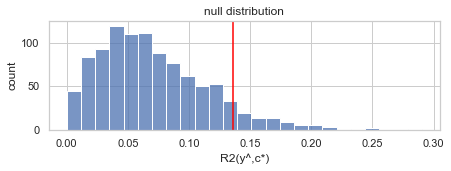

In [22]:
ret = partial_confound_test(y=df.mean_QST_pain_sensitivity,
                            yhat=predictions['multi-center'],
                            c=df.study.astype("category").cat.codes.values,
                            return_null_dist=True,
                            cat_c=True,
                            random_state=42)

sns.set(rc={'figure.figsize':(7,2)})
sns.set_style('whitegrid')
plot_null_dist(ret)
plt.savefig('../res/multi-center/center-bias-nulldist.pdf')
plot_graph(ret, outfile_base='../res/multi-center/center-bias')

In [47]:
np.sqrt(0.12)

0.34641016151377546

In [96]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
#r_obs_pred = np.corrcoef(df.mean_QST_pain_sensitivity, predictions['multi-center'])[0,1]

data = pd.DataFrame(
    {
        'observed': df.mean_QST_pain_sensitivity.values,
        'predicted': predictions['multi-center'],
        'confounder': df.study.astype("category").cat.codes.values
    })

fit=ols("observed ~ predicted", data=data).fit()
print("R^2_(observed ~ predicted) =", fit.rsquared)

fit=ols("observed ~ C(confounder)", data=data).fit()
print("R^2_(observed ~ C(confounder)) =", fit.rsquared)
r2_obs_conf_true = fit.rsquared

fit=ols("predicted ~ C(confounder)", data=data).fit()
print("R^2_(predicted ~ C(confounder) =", fit.rsquared)
r2_pred_conf_true = fit.rsquared


corrs=[]
nulldata=[]

tolerance = 0.01

rng = np.random.default_rng(42)

for i in tqdm(range(500000)):
    data_rs = pd.DataFrame(
    {
        'observed': df.mean_QST_pain_sensitivity.values,
        'predicted': predictions['multi-center'],
        'confounder': rng.permutation(df.study.astype("category").cat.codes.values)
    })
    r2_obs_conf_rs = ols("observed ~ C(confounder)", data=data_rs).fit().rsquared
    
    if (np.abs(r2_obs_conf_rs - r2_obs_conf_true) < tolerance):
        #print("Resampled R^2_(observed ~ C(confounder)) =", r2_obs_conf_rs)
        fit=ols("predicted ~ C(confounder)", data=data_rs).fit()
        #print("Resampled  R^2_(predicted ~ C(confounder) =", fit.rsquared)
        print(data_rs.confounder.values)
        
        nulldata.append(fit.rsquared)
        corrs.append(r2_obs_conf_rs)
        
sns.distplot(nulldata)
plt.axvline(r2_pred_conf_true)

print(len(nulldata))
print("p=", np.sum(nulldata>=r2_pred_conf_true)/len(nulldata))

        
    


  0%|          | 6/500000 [00:00<2:33:13, 54.38it/s]

R^2_(observed ~ predicted) = 0.40124317724014147
R^2_(observed ~ C(confounder)) = 0.12880847118030403
R^2_(predicted ~ C(confounder) = 0.13557816071589912



  0%|          | 363/500000 [00:12<5:11:30, 26.73it/s]

[2 1 2 1 1 0 1 1 1 0 2 1 1 1 1 0 0 1 0 2 0 0 0 1 2 1 0 0 1 2 0 1 2 1 1 1 2
 2 0 0 2 1 1 1 2 2 1 2 1 1 0 0 0 2 2 0 0 2 0 0 1 0 0 0 1 1 0 1 0 0 0 2 1 0
 2 0 1 1 1 0 0 0 0 1 1 2 0 1 0 1 1]



  0%|          | 1291/500000 [00:43<4:24:49, 31.39it/s]

[1 1 2 2 2 0 0 1 1 0 1 1 1 0 0 0 2 0 0 2 1 0 0 2 1 1 0 0 1 2 1 1 0 2 2 0 1
 0 0 0 1 2 1 1 0 1 0 1 1 0 1 2 1 0 1 1 1 1 0 0 1 2 1 0 0 1 0 2 1 1 0 1 2 0
 1 2 0 2 0 1 2 2 0 0 1 1 0 1 0 0 2]



  0%|          | 1644/500000 [00:53<4:13:38, 32.75it/s]

[1 0 1 1 0 0 1 1 1 1 1 0 0 1 1 2 0 1 0 1 1 2 1 1 2 1 1 2 2 2 1 1 2 2 1 2 0
 1 0 0 2 0 2 1 0 2 1 0 1 0 0 0 0 0 0 0 1 2 2 1 1 0 1 0 0 1 1 1 0 1 0 2 1 2
 1 0 0 2 1 0 0 0 0 0 1 2 0 0 0 2 1]



  0%|          | 1848/500000 [00:59<3:38:54, 37.93it/s]

[0 0 0 0 1 1 1 2 0 2 0 0 0 2 1 1 0 1 1 1 0 0 2 2 1 2 1 0 1 1 0 1 1 1 0 1 0
 0 2 1 1 1 0 1 2 0 2 0 0 0 1 0 0 2 0 1 2 1 1 2 0 2 1 0 1 1 1 2 0 1 1 1 1 0
 0 1 0 2 2 2 0 1 1 0 2 0 2 0 0 1 1]



  0%|          | 2112/500000 [01:07<4:53:57, 28.23it/s]

KeyboardInterrupt: 

permuting:   0%|          | 6/100000 [00:00<28:44, 57.98it/s]

R^2_(observed ~ predicted) = 0.40124317724014147
R^2_(observed ~ C(confounder)) = 0.12880847118030403
R^2_(predicted ~ C(confounder) = 0.13557816071589912


permuting: 100%|██████████| 100000/100000 [04:46<00:00, 349.47it/s]


2715
p= 0.02283609576427256


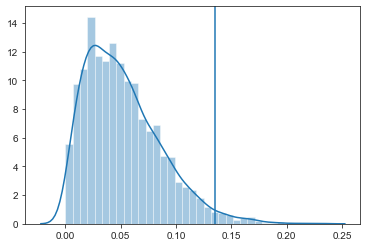

In [87]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import importlib
import contextlib
import joblib
from joblib import Parallel, delayed

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """
    Context manager to patch joblib to report into tqdm progress bar given as argument
    Based on: https://stackoverflow.com/questions/37804279/how-can-we-use-tqdm-in-a-parallel-execution-with-joblib
    """
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()
#r_obs_pred = np.corrcoef(df.mean_QST_pain_sensitivity, predictions['multi-center'])[0,1]

data = pd.DataFrame(
    {
        'observed': df.mean_QST_pain_sensitivity.values,
        'predicted': predictions['multi-center'],
        'confounder': df.study.astype("category").cat.codes.values
    })

fit=ols("observed ~ predicted", data=data).fit()
print("R^2_(observed ~ predicted) =", fit.rsquared)

fit=ols("observed ~ C(confounder)", data=data).fit()
print("R^2_(observed ~ C(confounder)) =", fit.rsquared)
r2_obs_conf_true = fit.rsquared

fit=ols("predicted ~ C(confounder)", data=data).fit()
print("R^2_(predicted ~ C(confounder) =", fit.rsquared)
r2_pred_conf_true = fit.rsquared


corrs=[]
nulldata=[]

tolerance = 0.05



def workhorse(i):
    rng = np.random.default_rng(42+i)
    data_rs = pd.DataFrame(
        {
        'observed': df.mean_QST_pain_sensitivity.values,
        'predicted': predictions['multi-center'],
        'confounder': rng.permutation(df.study.astype("category").cat.codes.values)
        })
    r2_obs_conf_rs = ols("observed ~ C(confounder)", data=data_rs).fit().rsquared
    
    if (np.abs(r2_obs_conf_rs - r2_obs_conf_true) < tolerance):
        #print("Resampled R^2_(observed ~ C(confounder)) =", r2_obs_conf_rs)
        fit=ols("predicted ~ C(confounder)", data=data_rs).fit()
        #print("Resampled  R^2_(predicted ~ C(confounder) =", fit.rsquared)     
        return fit.rsquared, r2_obs_conf_rs
    return np.nan, np.nan
    
num_perms=100000  
with tqdm_joblib(tqdm(desc='permuting', total=num_perms)) as progress_bar:
            res = Parallel(n_jobs=-1)(delayed(workhorse)(i) for i in np.arange(num_perms))
    

nulldata, corrs = zip(*res)
nulldata = np.array(nulldata)
nulldata = nulldata[~np.isnan(nulldata)]
print(len(nulldata))
sns.distplot(nulldata)
plt.axvline(r2_pred_conf_true)

print("p=", np.sum(nulldata>=r2_pred_conf_true)/len(nulldata))

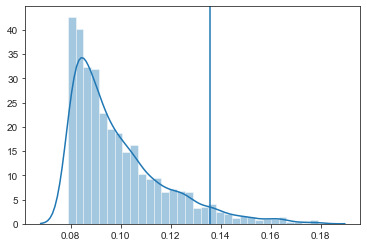

In [90]:
corrs = np.array(corrs)
sns.distplot(corrs[~np.isnan(corrs)])
plt.axvline(r2_pred_conf_true)

permuting:   0%|          | 0/1000000 [00:00<?, ?it/s]

R^2_(observed ~ predicted) = 0.40124317724014147
R^2_(observed ~ C(confounder)) = 0.12880847118030403
R^2_(predicted ~ C(confounder) = 0.13557816071589912


permuting: 100%|██████████| 1000000/1000000 [36:03<00:00, 462.32it/s] 


256
p= 0.03515625


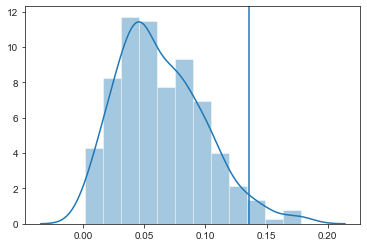

In [91]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import importlib
import contextlib
import joblib
from joblib import Parallel, delayed

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """
    Context manager to patch joblib to report into tqdm progress bar given as argument
    Based on: https://stackoverflow.com/questions/37804279/how-can-we-use-tqdm-in-a-parallel-execution-with-joblib
    """
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()
#r_obs_pred = np.corrcoef(df.mean_QST_pain_sensitivity, predictions['multi-center'])[0,1]

data = pd.DataFrame(
    {
        'observed': df.mean_QST_pain_sensitivity.values,
        'predicted': predictions['multi-center'],
        'confounder': df.study.astype("category").cat.codes.values
    })

fit=ols("observed ~ predicted", data=data).fit()
print("R^2_(observed ~ predicted) =", fit.rsquared)

fit=ols("observed ~ C(confounder)", data=data).fit()
print("R^2_(observed ~ C(confounder)) =", fit.rsquared)
r2_obs_conf_true = fit.rsquared

fit=ols("predicted ~ C(confounder)", data=data).fit()
print("R^2_(predicted ~ C(confounder) =", fit.rsquared)
r2_pred_conf_true = fit.rsquared


corrs=[]
nulldata=[]

tolerance = 0.001



def workhorse(i):
    rng = np.random.default_rng(4242+i)
    data_rs = pd.DataFrame(
        {
        'observed': df.mean_QST_pain_sensitivity.values,
        'predicted': predictions['multi-center'],
        'confounder': rng.permutation(df.study.astype("category").cat.codes.values)
        })
    r2_obs_conf_rs = ols("observed ~ C(confounder)", data=data_rs).fit().rsquared
    
    if (np.abs(r2_obs_conf_rs - r2_obs_conf_true) < tolerance):
        #print("Resampled R^2_(observed ~ C(confounder)) =", r2_obs_conf_rs)
        fit=ols("predicted ~ C(confounder)", data=data_rs).fit()
        #print("Resampled  R^2_(predicted ~ C(confounder) =", fit.rsquared)     
        return fit.rsquared, r2_obs_conf_rs
    return np.nan, np.nan
    
num_perms=1000000  
with tqdm_joblib(tqdm(desc='permuting', total=num_perms)) as progress_bar:
            res = Parallel(n_jobs=-1)(delayed(workhorse)(i) for i in np.arange(num_perms))
    

nulldata, corrs = zip(*res)
nulldata = np.array(nulldata)
nulldata = nulldata[~np.isnan(nulldata)]
print(len(nulldata))
sns.distplot(nulldata)
plt.axvline(r2_pred_conf_true)

print("p=", np.sum(nulldata>=r2_pred_conf_true)/len(nulldata))

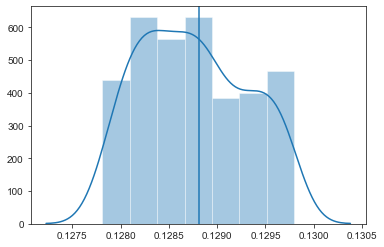

In [93]:
corrs = np.array(corrs)
sns.distplot(corrs[~np.isnan(corrs)])
plt.axvline(r2_obs_conf_true)

In [112]:
from scipy.stats import beta

def binom_interval(success, total, confint=0.95):
    quantile = (1 - confint) / 2.
    lower = beta.ppf(quantile, success, total - success + 1)
    upper = beta.ppf(1 - quantile, success + 1, total - success)
    return (lower, upper)

binom_interval(256*0.03515625, 256)

(0.016199410860957122, 0.06568621418387195)

## Predicted vs. Predicted plot

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


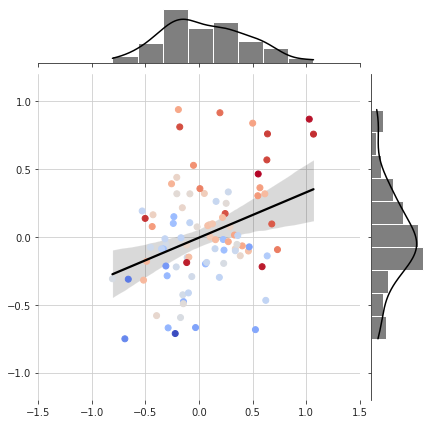

In [43]:
g=sns.jointplot(predictions['single-center'], predictions['multi-center'], kind='reg', color='black', scatter = False )
g.ax_joint.scatter(predictions['single-center'],predictions['multi-center'], c=df.mean_QST_pain_sensitivity,
                   cmap="coolwarm")
g.fig.set_size_inches(6,6)
g.ax_joint.set(xlabel=None) 
g.ax_joint.set_xlim([-1.5, 1.5])
g.ax_joint.set_ylim([-1.2, 1.2])
g.ax_joint.spines['top'].set_visible(False)
g.ax_joint.spines['bottom'].set_visible(False)
g.ax_joint.spines['right'].set_visible(False)
g.ax_joint.spines['left'].set_visible(False)
g.ax_joint.grid(True)
plt.savefig('../res/multi-center/regplots_pred-pred.pdf')  

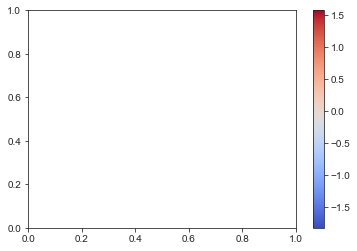

In [14]:
norm = plt.Normalize(df.mean_QST_pain_sensitivity.min(), df.mean_QST_pain_sensitivity.max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
plt.colorbar(sm)
plt.savefig('../res/multi-center/regplots_pred-pred_colorbar.pdf')  

In [15]:
corr = np.corrcoef(predictions['single-center'], predictions['multi-center'])[0,1]
print("R={:.2f}".format(corr))
        
# takes some seconds
p_corr = permutation_test(y[study_masks[study]], predictions[cv][study_masks[study]],
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
print("p_corr={:.5f}".format(p_corr))

R=0.35
p_corr=0.00000
